In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [2]:
from fastai.tabular import *

# Rossmann 建模

- `.label_from_df(cols=dep_var, label_cls=FloatList, log=True)` 如果 label_cls=FloatList 那么其是一个回归问题，如果为整数，那么就是一个分类问题
- dropout 扔掉的是激活值而不是权重
- 通常，我们只删除隐藏层中的激活。 每当我有一个 minibatch 通过，我随机扔掉一些激活。然后是下一个 minibatch ，我把它们放回去，然后扔掉一些不同的激活值

![](https://github.com/hiromis/notes/raw/master/lesson6/7.png)

In [3]:
path = Config.data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [4]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [5]:
train_df.shape
test_df.shape

(844338, 93)

(41088, 92)

In [6]:
procs=[FillMissing, Categorify, Normalize]

In [7]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [8]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [9]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [10]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [11]:
valid_idx = range(cut)

In [12]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [13]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [14]:
doc(FloatList)

class FloatList [source] [test] FloatList ( items : Iterator , log : bool = False , classes : Collection = None , ** kwargs ) :: ItemList 
 
 × No tests found for FloatList . To contribute a test please refer to this guide and this discussion . ItemList suitable for storing the floats in items for regression. Will add a log if this flag is True . 
 Show in docs

In [15]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [16]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [17]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


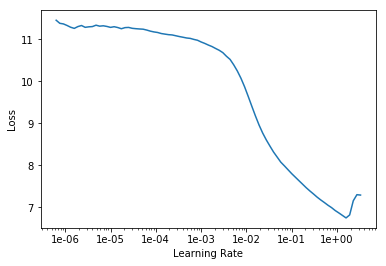

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, 3e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.028006,0.024756,0.154261,01:48
1,0.025776,0.027920,0.148853,01:50
2,0.022508,0.032421,0.196211,01:52
3,0.017426,0.016468,0.127592,01:55
4,0.016923,0.012605,0.112541,01:48


In [20]:
learn.save('s1')

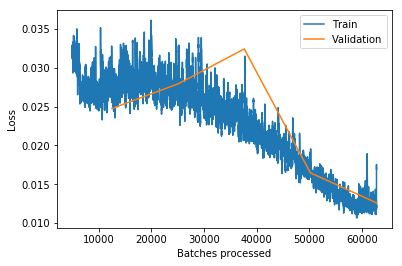

In [21]:
learn.recorder.plot_losses(skip_start=5000)

In [22]:
learn.load('s1');

In [23]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.012959,0.012961,0.112380,01:49
1,0.011960,0.012186,0.108741,01:57
2,0.011300,0.012701,0.108706,01:56
3,0.010804,0.013819,0.110699,01:55
4,0.010680,0.013981,0.110969,02:06


In [ ]:
learn.save('s2')

- 预测

In [29]:
learn.load('s2');

In [30]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv(path/"submission.csv",index=False)

- 提交

In [33]:
!kaggle competitions submit rossmann-store-sales -f {path/'submission.csv'} -m "My submission"

  0%|                                                | 0.00/433k [00:00<?, ?B/s]2019-05-10 17:07:03,263 WARNING Retrying (Retry(total=9, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f042412f550>: Failed to establish a new connection: [Errno 110] Connection timed out',)': /upload/storage/v1/b/kaggle-competitions-submissions/o?uploadType=resumable&upload_id=AEnB2UoQq6rUNqbuHmNpFKLAKeh_cRAZQaB_2dO8ucCkkM6OHZvYt7_-WdGrgSwErpcMfAw5R-kPkjdhvuHZmWER6-yDIXtMZ-vUokqACvuS96gYw4A4OGo
2019-05-10 17:11:26,404 WARNING Retrying (Retry(total=8, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f042412f630>: Failed to establish a new connection: [Errno 110] Connection timed out',)': /upload/storage/v1/b/kaggle-competitions-submissions/o?uploadType=resumable&upload_id=AEnB2UoQq6rUNqbu

In [34]:
test_df.shape

(41088, 93)